# Automating Forecasting at Scale

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt

# Time Series Forecasting
from prophet import Prophet
# Metrics
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
# Plots
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly, plot_weekly
from prophet.plot import add_changepoints_to_plot

# Warnings
import warnings

# TQDM Notebook
from tqdm.notebook import tqdm

# Itertools
from itertools import product

# Machine Learning Metrics
from sklearn.metrics import mean_absolute_error

# Statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

#### Loading Data

In [4]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


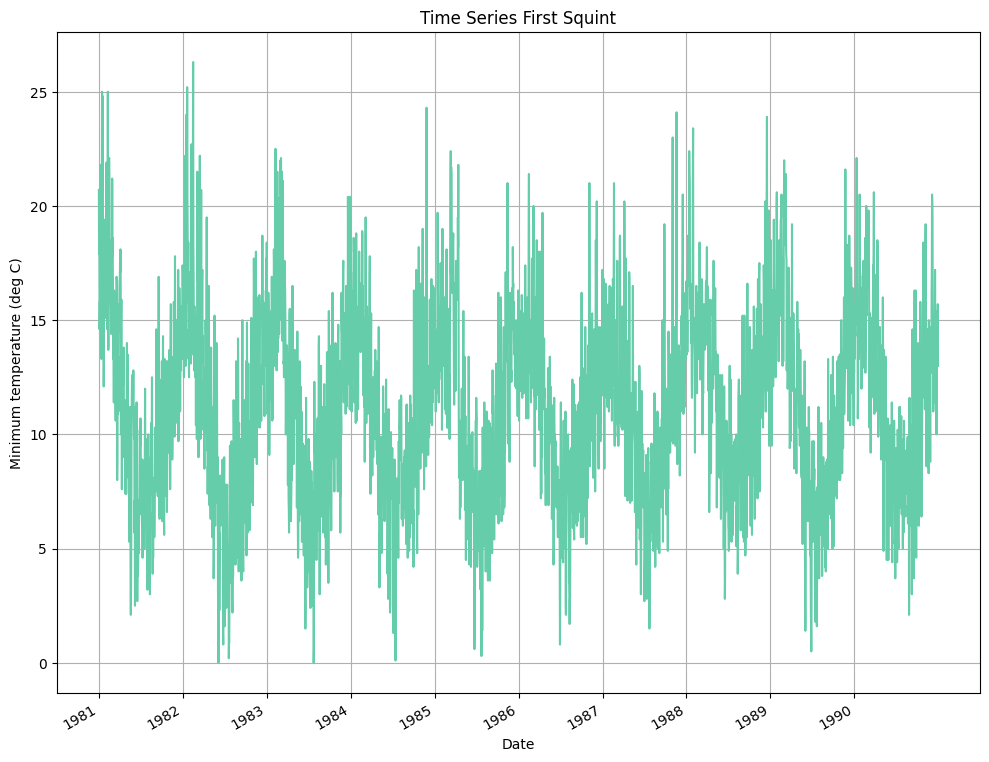

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Temp'], color='mediumaquamarine')
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

plt.xticks(np.arange(0, 3649, 365), np.arange(1981, 1991, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Time Series First Squint')
plt.show()

### Basic forecasting with Prophet

##### Renaming Columns

In [7]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


##### Split & Train Procedure

In [8]:
# Train set
train = df[:-365]
# Test set
test = df[-365:]

In [9]:
# Model Initialization
m = Prophet()

In [10]:
# Fitting & Training Model
m.fit(train);

11:19:51 - cmdstanpy - INFO - Chain [1] start processing
11:19:51 - cmdstanpy - INFO - Chain [1] done processing


##### Setting a Prediction DataFrame

In [11]:
# Make Future DataFrame
future = m.make_future_dataframe(periods=365)

##### Generating Predictions

In [12]:
# Predictions 
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-365:-360]

,ds,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.884813,11.280583,18.149745
3286,1990-01-02,15.011285,11.634635,18.680993
3287,1990-01-03,15.087727,11.785292,18.672978
3288,1990-01-04,14.995843,11.510380,18.469136
3289,1990-01-05,15.066143,11.523275,18.402872


In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3645,1990-12-27,11.408331,11.056550,17.854680,11.301425,11.507928,3.043486,3.043486,3.043486,-0.026437,-0.026437,-0.026437,3.069923,3.069923,3.069923,0.0,0.0,0.0,14.451816
3646,1990-12-28,11.408249,10.743556,17.873246,11.300926,11.508399,3.120829,3.120829,3.120829,-0.009961,-0.009961,-0.009961,3.130790,3.130790,3.130790,0.0,0.0,0.0,14.529079
3647,1990-12-29,11.408168,11.079214,17.980313,11.300429,11.508461,3.144904,3.144904,3.144904,-0.048861,-0.048861,-0.048861,3.193765,3.193765,3.193765,0.0,0.0,0.0,14.553072
3648,1990-12-30,11.408086,11.001640,17.944654,11.299896,11.509021,3.069384,3.069384,3.069384,-0.188709,-0.188709,-0.188709,3.258093,3.258093,3.258093,0.0,0.0,0.0,14.477471
3649,1990-12-31,11.408005,11.364870,18.220548,11.299457,11.509407,3.366622,3.366622,3.366622,0.043661,0.043661,0.043661,3.322962,3.322962,3.322962,0.0,0.0,0.0,14.774627


##### Forecasting with Test

In [14]:
# Joining test to set a single DataFrame
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.8,14.884813,11.280583,18.149745
3286,1990-01-02,13.3,15.011285,11.634635,18.680993
3287,1990-01-03,15.6,15.087727,11.785292,18.672978
3288,1990-01-04,14.5,14.995843,11.510380,18.469136
3289,1990-01-05,14.3,15.066143,11.523275,18.402872


##### Setting Baseline Benchmark Model

In [15]:
test['baseline'] = train['y'][-365:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.884813,11.280583,18.149745,14.3
3286,1990-01-02,13.3,15.011285,11.634635,18.680993,17.4
3287,1990-01-03,15.6,15.087727,11.785292,18.672978,18.5
3288,1990-01-04,14.5,14.995843,11.510380,18.469136,16.8
3289,1990-01-05,14.3,15.066143,11.523275,18.402872,11.5


##### Setting Interpretability Model Metrics with (MAE)

In [16]:
# Mean Absolute Error on Prophet
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

In [17]:
# Metric Outcomes
print(prophet_mae)
print(baseline_mae)

1.9372369140969206
2.8673972602739726


In [18]:
test.iloc[33]

ds            1990-02-03
y                   14.8
yhat           15.445169
yhat_lower     11.584185
yhat_upper     19.045057
baseline            16.3
Name: 3318, dtype: object

##### Forecast & Confidence Interval Visualization

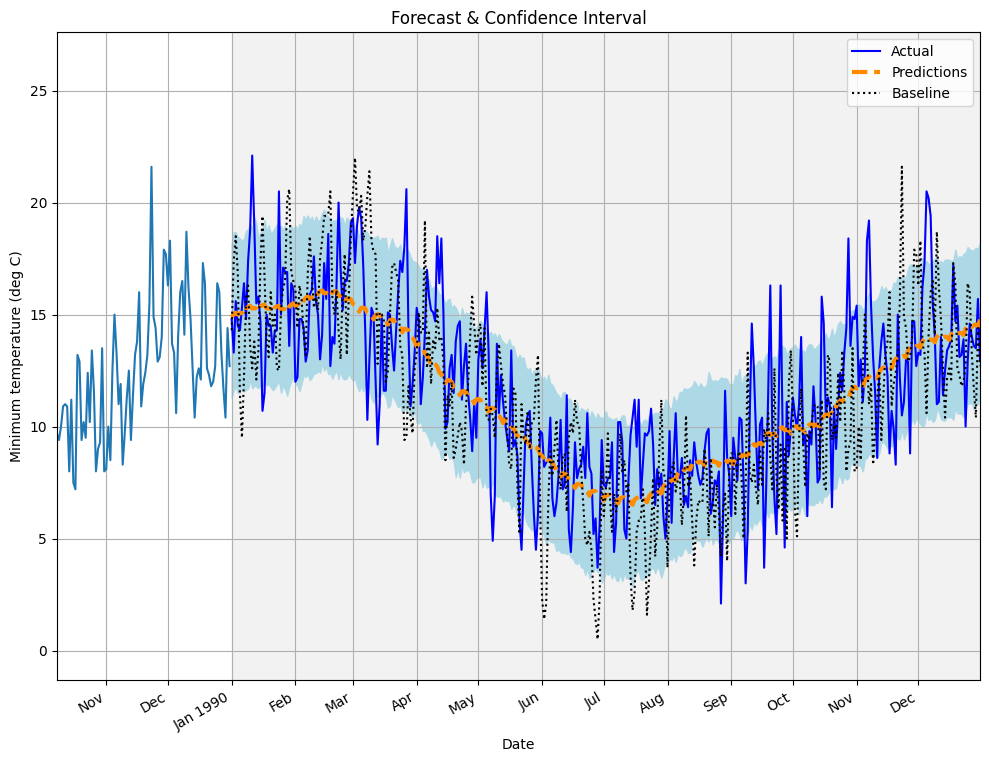

In [19]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(
    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Forecast & Confidence Interval')
plt.show()

### Prophet's Advance Functionality

##### Visualization Capabilities

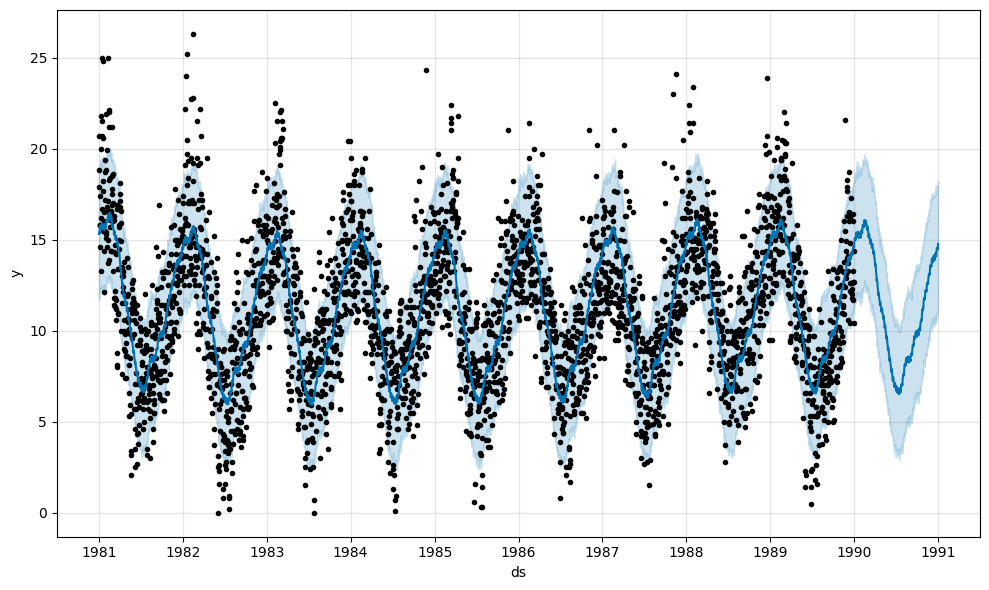

In [20]:
fig1 = m.plot(forecast)

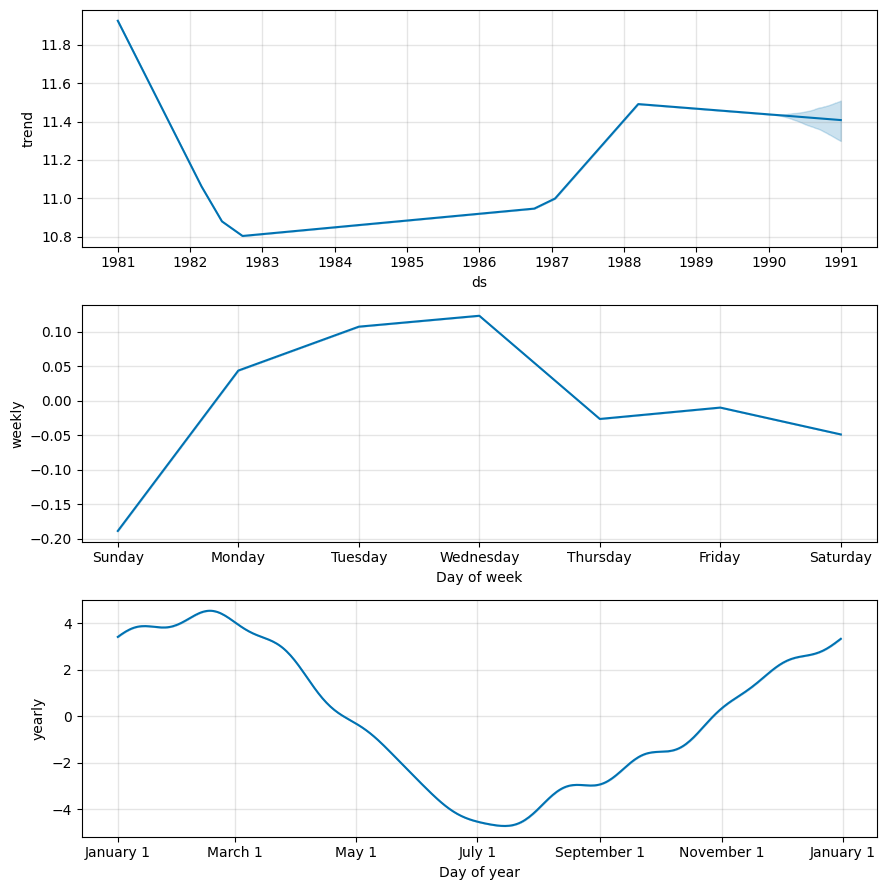

In [21]:
# Plotting Components
fig2 = m.plot_components(forecast)

##### Only Seasonal Component

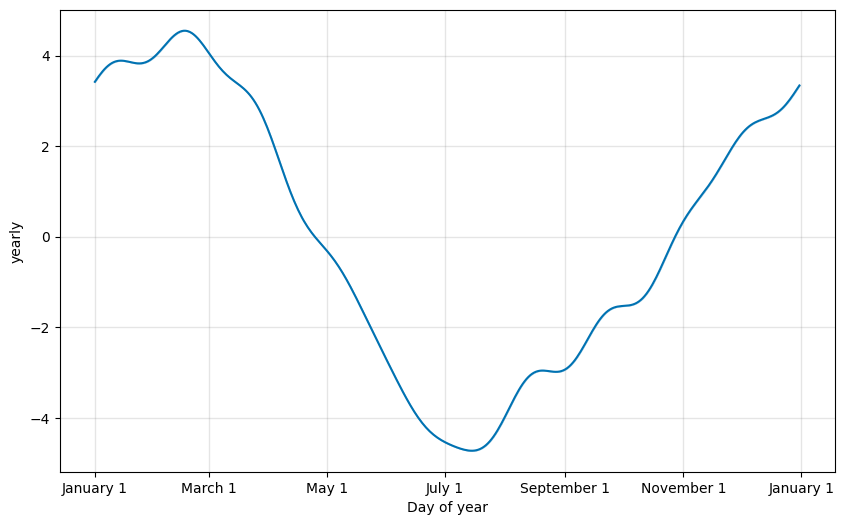

In [22]:
# Yearly
fig4 = plot_yearly(m)

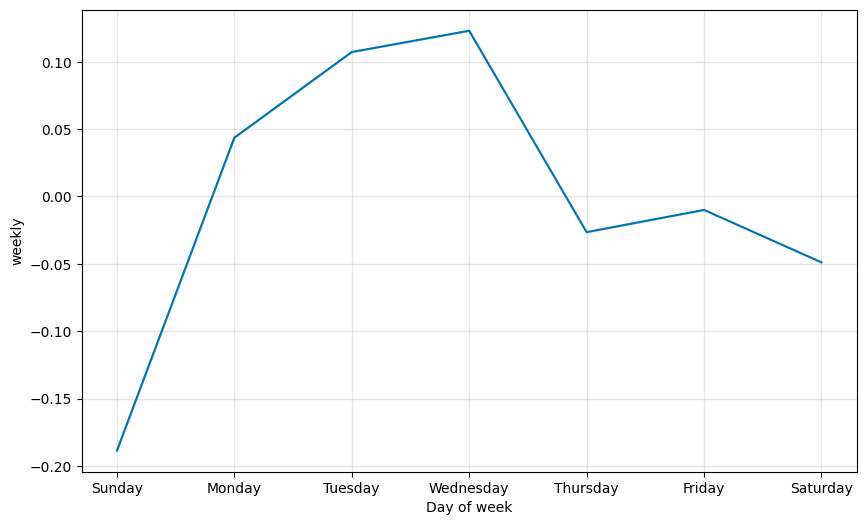

In [23]:
# Weekly
fig5 = plot_weekly(m)

11:20:07 - cmdstanpy - INFO - Chain [1] start processing
11:20:07 - cmdstanpy - INFO - Chain [1] done processing


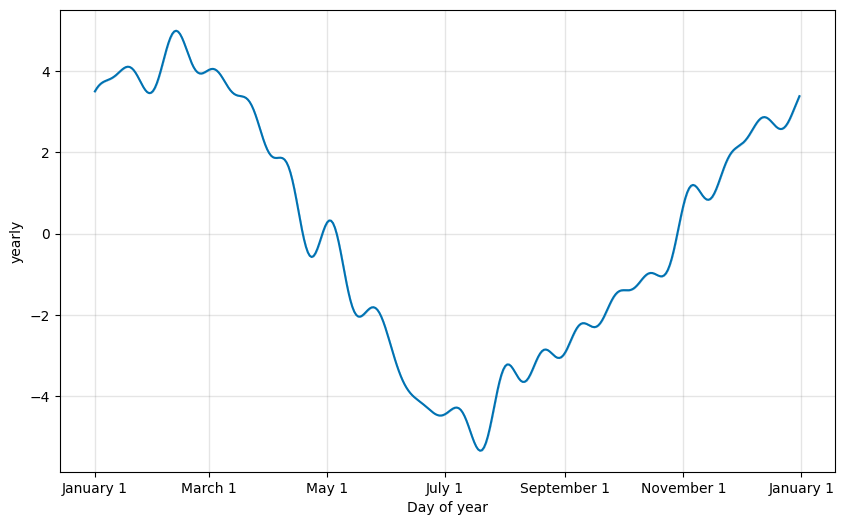

In [24]:
# Based on 20 seasonal terms
m2 = Prophet(yearly_seasonality=20).fit(train)

fig6 = plot_yearly(m2)

#### Identifying Unique Trends

##### Trend's Changepoint

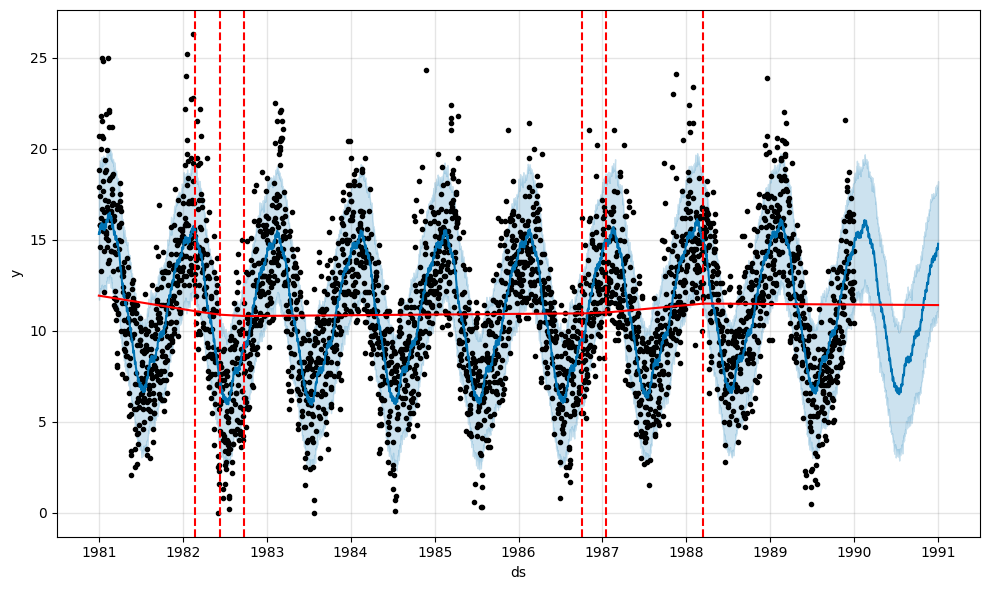

In [25]:
fig3 = m.plot(forecast)
# Changepoint's to plot
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

### Cross-Validation & Performance Metrics

#### Setting Data

In [26]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

df_cv.head()

11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] start processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:14 - cmdstanpy - INFO - Chain [1] done processing
11:20:15 - cmdstanpy - INFO - Chain [1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-02-02,15.180760,11.475599,18.922348,17.3,1983-02-01
1,1983-02-03,14.843227,11.174381,18.435150,13.0,1983-02-01
2,1983-02-04,15.238653,11.670715,18.646478,16.0,1983-02-01
3,1983-02-05,15.230166,11.886349,18.633311,14.9,1983-02-01
4,1983-02-06,15.277526,11.700169,18.948221,16.2,1983-02-01


##### Model Performance Evaluation

In [27]:
df_perf = performance_metrics(df_cv, rolling_window=0)

df_perf.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,6.343070,2.518545,2.070920,0.150126,0.198579,0.846154
1,2 days,4.688372,2.165265,1.746947,0.141787,0.161501,0.846154
2,3 days,10.002355,3.162650,2.657245,0.146937,0.371581,0.769231
3,4 days,8.643322,2.939953,2.374467,0.195721,0.328718,0.692308
4,5 days,8.195715,2.862816,2.560727,0.195882,0.300317,0.615385


##### Horizon Metric Evaluation

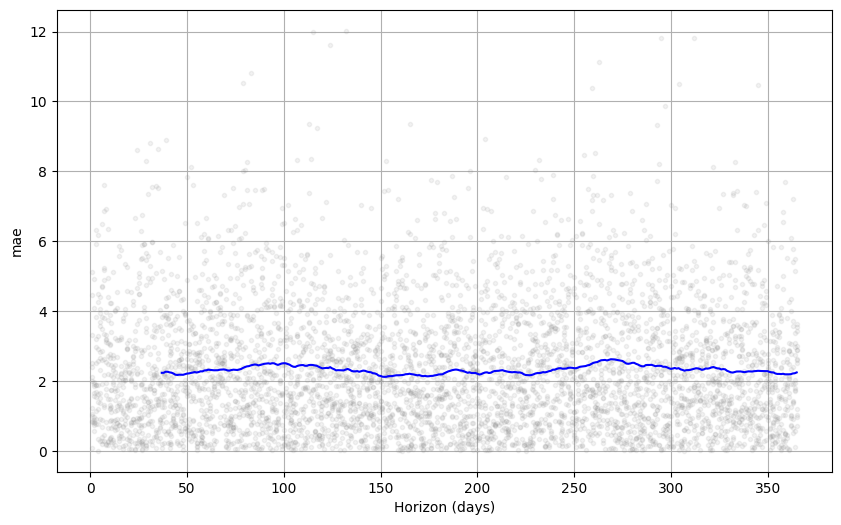

In [28]:
fig7 = plot_cross_validation_metric(df_cv, metric='mae')

### Hyperparameter Tuning

In [29]:
# Parameters Grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# List of Unique Parameters Combination
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

# Unique Iteration Steps
for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Setting Results within a DataFrame
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

11:20:23 - cmdstanpy - INFO - Chain [1] start processing
11:20:23 - cmdstanpy - INFO - Chain [1] done processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] done processing
11:20:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] done processing
11:20:24 - cmdstanpy - INFO - Chain [1] done processing
11:20:24 - cmdstanpy - INFO - Chain [1] done processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] start processing
11:20:24 - cmdstanpy - INFO - Chain [1] done proces

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,2.312803
1,0.001,0.10,2.313993
2,0.001,1.00,2.342393
3,0.001,10.00,2.341224
4,0.010,0.01,2.240415
5,0.010,0.10,2.278294
6,0.010,1.00,2.276686
7,0.010,10.00,2.280470
8,0.100,0.01,2.668172
9,0.100,0.10,2.346970


In [31]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


### Implementing a Robust Forecasting Process with Prophet

#### Forecasting project: Predicting the popularity of "chocolate" searches on Google

In [32]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/monthly_chocolate_search_usa.csv')
df.head()

,month,chocolate
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33
